In [8]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".30"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from scipy.interpolate import griddata
import flowrec.training_and_states as state_utils
import flowrec.losses as losses
import utils.simulation2d as project
import flowrec.data as data_utils

import jax
import jax.numpy as jnp
import optax
import haiku as hk

In [2]:
# train_test_split = [70,20,10]
train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [31] # size of the intermediate layers
cnn_channels = [31,3]
cnn_filter = [(3,3)]
dropout_rate = 0.02
regularisation_strength = 0.0001
epochs = 10
nb_batches = 6
data_dir = Path("./local_data/re100")
# data_dir = Path("/home/ym917/Results/simulations/triangle")

In [3]:
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# use only a subset of data for test
x = x[:,:,:200,:]

[x_train,x_val,x_test], _ = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=False,SHUFFLE=False)
# [x_train,x_val,x_test], [xm_train,xm_val,xm_test] = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=True,SHUFFLE=False)

[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


triangle_base_coords = [49,80]
pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


(nt,nx,ny) = ux_train.shape
n_base = pb_train.shape[-1]

mlp_layers.extend([3*nx*ny])

dx = 12/512
dy = 4/128
dt = 0.0002*625

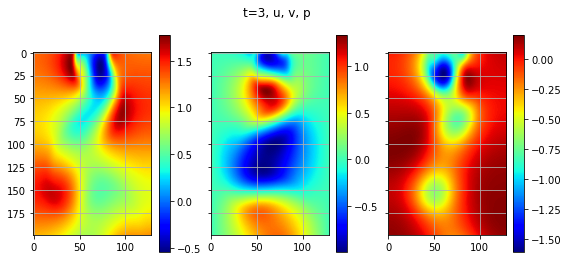

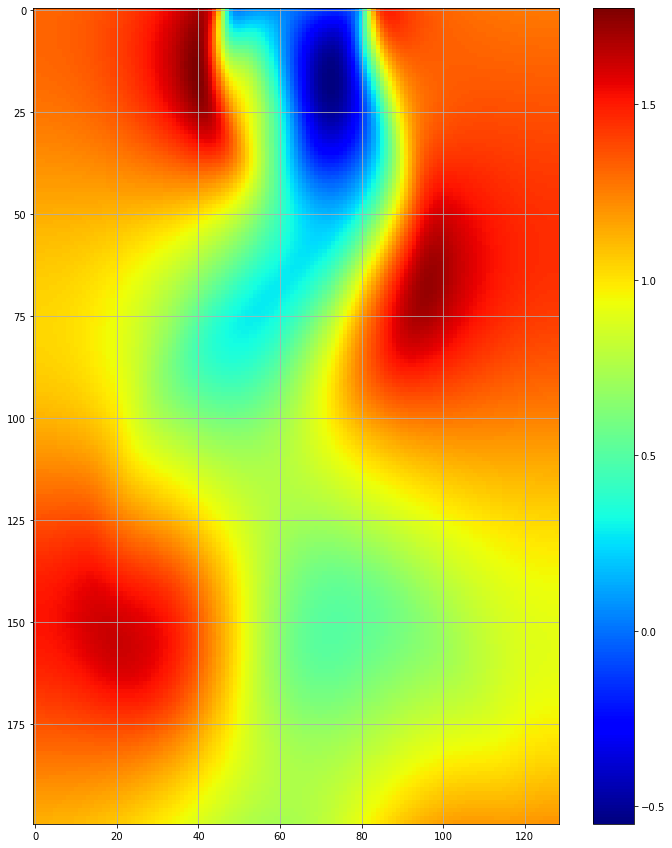

In [58]:
fig,axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=(9,4))
plt_t = 3
for i,ax in enumerate(axes):
    im = ax.imshow(x_train[i,plt_t,...],'jet')
    im = plt.colorbar(im,ax=ax)
    ax.grid('both')
fig.suptitle(f't={plt_t}, u, v, p')
plt.show()
plt.figure(figsize=(12,15))
plt.imshow(x_train[0,plt_t,...],'jet')
plt.colorbar()
plt.grid('both')
plt.show()

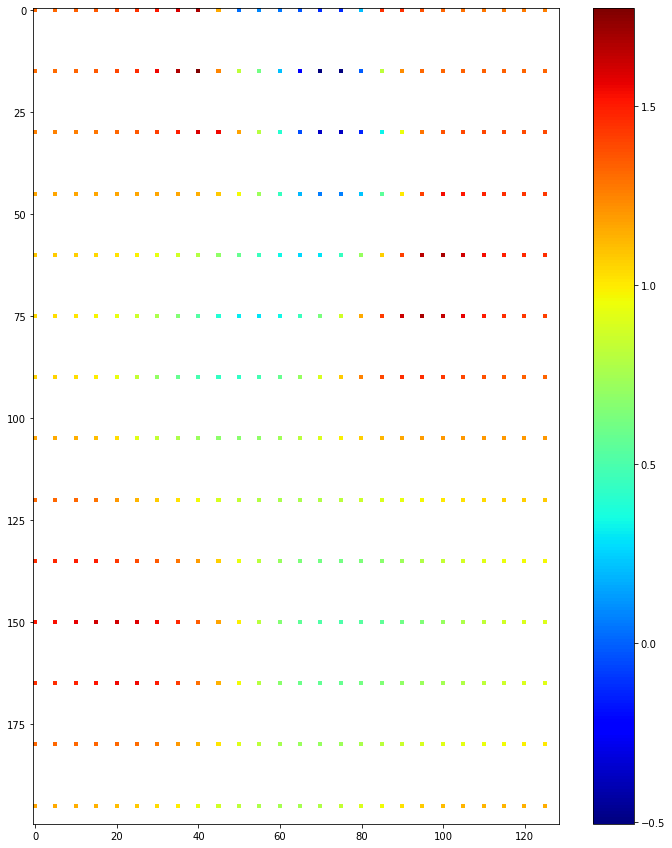

In [34]:
sensor_slicing_space = np.s_[::15,::5]
sensor_slicing = (np.s_[:],) + sensor_slicing_space

observed_ux = np.empty_like(ux_train)
observed_ux.fill(np.nan)
observed_ux[sensor_slicing] = ux_train[sensor_slicing]
observed_uy = np.empty_like(uy_train)
observed_uy.fill(np.nan)
observed_uy[sensor_slicing] = uy_train[sensor_slicing]
observed_pp = np.empty_like(pp_train)
observed_pp.fill(np.nan)
observed_pp[sensor_slicing] = pp_train[sensor_slicing]
observed_train = np.stack((observed_ux,observed_uy,observed_pp),axis=-1)



plt.figure(figsize=(12,15))
plt.imshow(observed_ux[3,...],'jet')
plt.colorbar()
plt.show()

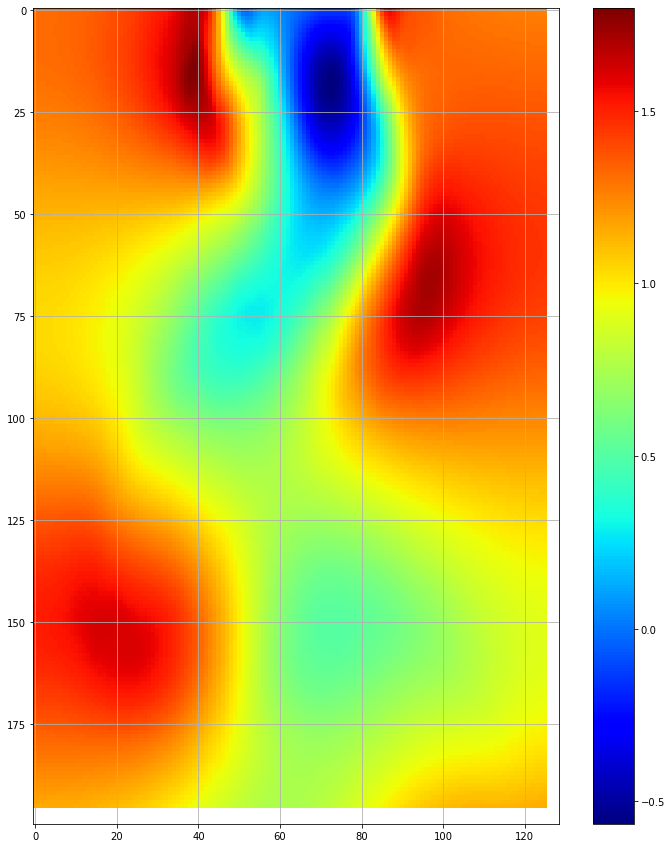

In [56]:
grid_x,grid_y = np.mgrid[0:observed_ux.shape[1], 0:observed_ux.shape[2]]
sensors_loc_x = grid_x[sensor_slicing_space]
sensors_loc_y = grid_y[sensor_slicing_space]
sensors_loc = np.stack((sensors_loc_x.flatten(),sensors_loc_y.flatten()),axis=-1)
data_interp = griddata(sensors_loc, observed_ux[(np.s_[3],)+sensor_slicing_space].flatten(), (grid_x,grid_y), method='cubic')
plt.figure(figsize=(12,15))
plt.imshow(data_interp,'jet')
plt.colorbar()
plt.grid('both')
plt.show()

Define network

In [36]:
from flowrec.models.cnn import Model
rng = jax.random.PRNGKey(19)

In [37]:
import logging
logging.getLogger('fr.flowrec.models.cnn').setLevel(logging.DEBUG)

In [38]:
mdl = Model(mlp_layers,output_shape=(nx,ny,3),cnn_channels=cnn_channels,cnn_filters=cnn_filter)
params = mdl.init(rng,pb_train)
optimiser = optax.adamw(learning_rate=learning_rate,weight_decay=regularisation_strength)
opt_state = optimiser.init(params)

fr.flowrec.models.cnn.__init__:146 [INFO] Successfully created model.
fr.flowrec.models.cnn.__init__:51 [INFO] Received only one convolution filter size, use the same size filter for all layers.
fr.flowrec.models.cnn.__call__:73 [INFO] Model is called in training mode.
fr.flowrec.models.cnn.__call__:82 [DEBUG] Output of the MLP has shape (600, 77400).
fr.flowrec.models.cnn.__call__:86 [DEBUG] Reshaped the output of MLP to (600, 200, 129, 3).


In [39]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'mlp_with_cnn/~/convolve_0': {'b': (31,), 'w': (3, 3, 3, 31)},
 'mlp_with_cnn/~/convolve_1': {'b': (3,), 'w': (3, 3, 31, 3)},
 'mlp_with_cnn/~/mlp/~/linear_0': {'b': (31,), 'w': (31, 31)},
 'mlp_with_cnn/~/mlp/~/linear_1': {'b': (77400,), 'w': (31, 77400)}}

In [40]:
u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_train.shape

(600, 200, 129, 3)

In [41]:
observed_train.shape
num_observed = jnp.sum(~jnp.isnan(observed_train))

In [67]:
def mse_sensors(pred,observed):
    # diff = (pred[sensor_slicing] - observed[sensor_slicing])**2
    # loss = jnp.sum(diff)/num_observed
    # loss = jnp.mean(diff)
    
    # return loss

    return losses.mse(pred[sensor_slicing],observed[sensor_slicing])

In [43]:
def divergence(
    ux,
    uy,
    dx,
    dy,
    x_axis,
    y_axis,
    uz=None,
    dz=None,
    z_axis=None)-> float:
    div_field = losses.get_div_field(ux,uy,dx,dy,x_axis,y_axis,uz=uz,dz=dz,z_axis=z_axis)
    div_loss = jnp.mean(div_field**2) # div_loss >= 0
    return div_loss

def momentum_residue(
    which_velocity,
    ux,
    uy,
    p,
    re,
    dt,
    dx,
    dy,
    axis_idx, # [t,x,y,z]
    **kwargs):
    
    if not (jnp.isscalar(re) and jnp.isscalar(dt) and jnp.isscalar(dx) and jnp.isscalar(dy)):
        raise ValueError('Reynolds number, dt, dx and dy must be scalars.')

    if len(axis_idx) == 3:
        axt,axx,axy = axis_idx
    elif len(axis_idx) == 4:
        axt,axx,axy,axz = axis_idx
    else:
        raise ValueError('Momentum residue can only calculate 2D or 3D mometum.')
    
    # set up which velocity 
    if which_velocity == 1:
        u = ux
        axp = axx
        p_dx = dx
    elif which_velocity == 2:
        u = uy
        axp = axy
        p_dx = dy
    elif which_velocity == 3:
        if ('uz' in kwargs) and ('dz' in kwargs) and ('axz' in locals()):
            uz = kwargs['uz']
            dz = kwargs['dz']
        else:
            raise ValueError('Missing uz, dz, or index for z axis.')
        u = uz
        axp = axz
        p_dx = dz
    else:
        raise ValueError('Please set "which_velocity" to 1/2/3 for ux/uy.uz')

    dudt = jnp.gradient(u,dt,axis=axt)

    dudx = jnp.gradient(u,dx,axis=axx)
    d2udx2 = jnp.gradient(dudx,dx,axis=axx)
    ux_dudx = ux*dudx

    dudy = jnp.gradient(u,dy,axis=axy)
    d2udy2 = jnp.gradient(dudy,dy,axis=axy)
    uy_dudy = uy*dudy

    dp = jnp.gradient(p,p_dx,axis=axp)

    residue = dudt + ux_dudx + uy_dudy + dp - (d2udx2 + d2udy2)/re

    if which_velocity == 3:
        dudz = jnp.gradient(u,dz,axis=axz)
        d2udz2 = jnp.gradient(dudz,dz,axis=axz)
        uz_dudz = uz*dudz
        residue = residue + uz_dudz - d2udz2/re
    
    return residue

In [68]:
def loss_fn(apply_fn,params,rng,x,y):
    # pred = apply_fn(params,rng,x).reshape((-1,200,129,3))
    pred = apply_fn(params,rng,x)
    loss_div = divergence(pred[...,0],pred[...,1],dx,dy,1,2)
    loss_mom_x = jnp.mean(momentum_residue(1,
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2],
                            re=100,
                            dt=dt,
                            dx=dx,
                            dy=dy,
                            axis_idx=[0,1,2])**2
                            )
    loss_mom_y = jnp.mean(momentum_residue(2,
                            ux=pred[...,0],
                            uy=pred[...,1],
                            p=pred[...,2],
                            re=100,
                            dt=dt,
                            dx=dx,
                            dy=dy,
                            axis_idx=[0,1,2])**2
                            )
    
    # loss_physics = loss_div + loss_mom_x + loss_mom_y
    # print(f'total physics loss: {loss_physics} -- div: {loss_div}, x momentum:{loss_mom_x}, y momentum: {loss_mom_y}')

    loss_sensor = mse_sensors(pred,y)
    # print(f'sensor loss: {loss_sensor}')

    return loss_div+(loss_mom_x+loss_mom_y-0.013)**2+loss_sensor, (loss_div,loss_mom_x+loss_mom_y,loss_sensor)
    # return loss_sensor,(loss_div,loss_mom_x+loss_mom_y,loss_sensor)

In [ ]:
from jax.config import config
config.update("jax_debug_nans", True)

In [69]:
update = state_utils.generate_update_fn(mdl.apply,optimiser,loss_fn,kwargs_value_and_grad={'has_aux':True})

In [70]:
state = state_utils.TrainingState(params,opt_state)

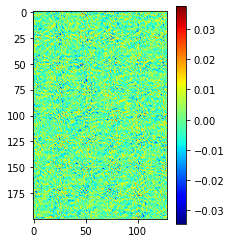

In [71]:
pred = mdl.apply(state.params,rng,pb_train[:10,:])

fig = plt.figure(figsize=(3,4))
plt.imshow(pred[3,:,:,0],'jet')
plt.colorbar()
plt.show()


In [72]:
observed_train_zeros = np.nan_to_num(observed_train)
hist_loss = []
hist_div = []
hist_div = []
hist_momentum = []
hist_data = []

fr.flowrec.models.cnn.__init__:51 [INFO] Received only one convolution filter size, use the same size filter for all layers.
fr.flowrec.models.cnn.__call__:73 [INFO] Model is called in training mode.
fr.flowrec.models.cnn.__call__:82 [DEBUG] Output of the MLP has shape (10, 77400).
fr.flowrec.models.cnn.__call__:86 [DEBUG] Reshaped the output of MLP to (10, 200, 129, 3).


0: 0.617448091506958
50: 0.4177778363227844
100: 0.3091706931591034
150: 0.20524968206882477
200: 0.11587896943092346
250: 0.07880859822034836
300: 0.06522401422262192
350: 0.05392666533589363
400: 0.044312454760074615
450: 0.03588581830263138
500: 0.02868564799427986
550: 0.022760476917028427
600: 0.018475685268640518
650: 0.015591942705214024
700: 0.013559013605117798
750: 0.011919381096959114
800: 0.010590699501335621
850: 0.009299584664404392
900: 0.008252725005149841
950: 0.007383313030004501
1000: 0.006379575468599796
1050: 0.005647393874824047
1100: 0.004961991682648659
1150: 0.004427097737789154
1200: 0.003923151176422834
1250: 0.0035320271272212267
1300: 0.003166233655065298
1350: 0.002966509200632572
1400: 0.0027161771431565285
1450: 0.0025862911716103554
1500: 0.002324925735592842
1550: 0.002061153994873166
1600: 0.0019619716331362724
1650: 0.0019222473492845893
1700: 0.0017427095444872975
1750: 0.001609085826203227
1800: 0.001565637532621622
1850: 0.0014935759827494621
1900

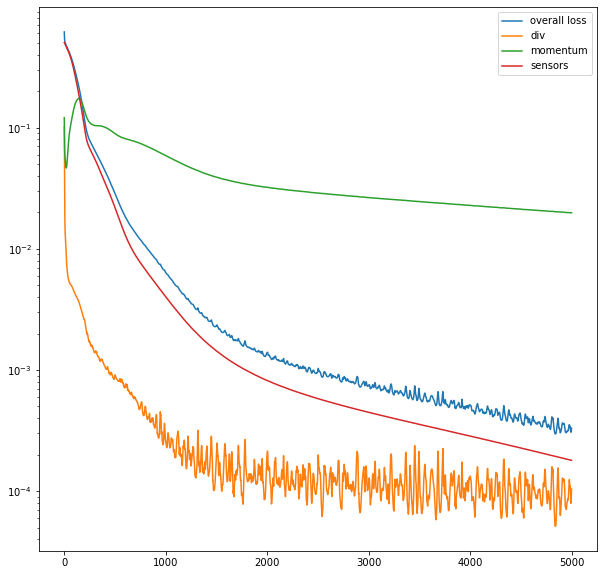

In [73]:
# loss, state = update(state,rng,pb_train[:10,:],observed_train[:10,:])
for i in range(5001):
    (loss, (loss_div, loss_momentum, loss_data)),state = update(state,rng,pb_train[:10,:],observed_train_zeros[:10,:])
    hist_loss.append(loss)
    hist_div.append(loss_div)
    hist_momentum.append(loss_momentum)
    hist_data.append(loss_data)
    if i%50==0:
        print(f'{i}: {loss}')

plt.figure(figsize=(10,10))
plt.plot(hist_loss,label='overall loss')
plt.plot(hist_div,label='div')
plt.plot(hist_momentum,label='momentum')
plt.plot(hist_data,label='sensors')
plt.yscale('log')
plt.legend()
plt.show()

div: 0.00011057088704546914, momentum: 0.019865985959768295, physcis: 0.019976556301116943, sensor: 0.00017953742644749582


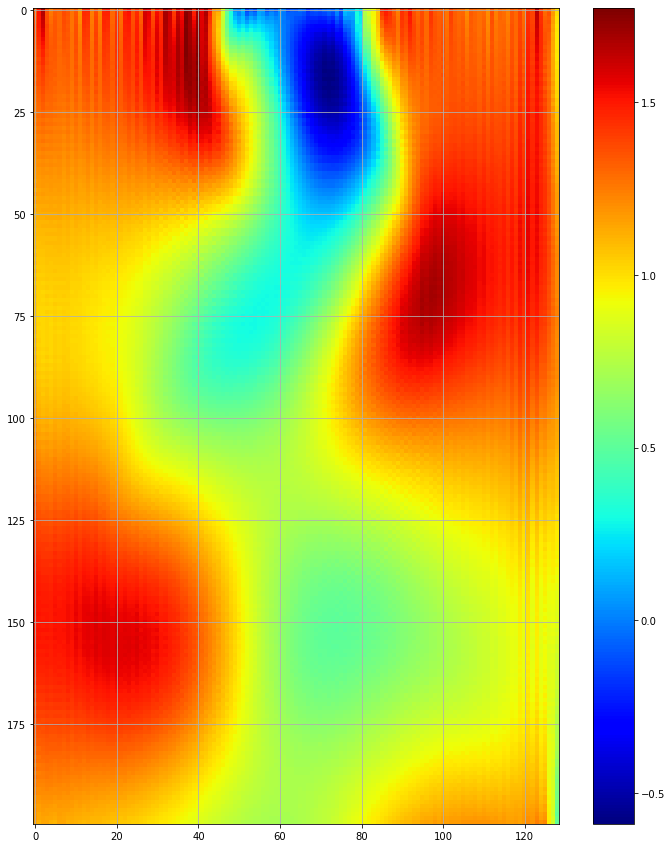

In [74]:
pred = mdl.apply(state.params,None,pb_train[:10,:])
    
loss_div = divergence(pred[...,0],pred[...,1],dx,dy,1,2)
loss_mom_x = jnp.mean(losses.momentum_residue(1,
                        ux=pred[...,0],
                        uy=pred[...,1],
                        p=pred[...,2],
                        re=100,
                        dt=dt,
                        dx=dx,
                        dy=dy,
                        axis_idx=[0,1,2])**2
                        )
loss_mom_y = jnp.mean(losses.momentum_residue(2,
                        ux=pred[...,0],
                        uy=pred[...,1],
                        p=pred[...,2],
                        re=100,
                        dt=dt,
                        dx=dx,
                        dy=dy,
                        axis_idx=[0,1,2])**2
                        )
loss_sensor = mse_sensors(pred,observed_train_zeros[:10,...])
print(f'div: {loss_div}, momentum: {loss_mom_x + loss_mom_y}, physcis: {loss_div+loss_mom_x+loss_mom_y}, sensor: {loss_sensor}')

fig = plt.figure(figsize=(12,15))
plt.imshow(pred[3,:,:,0],'jet')
plt.colorbar()
plt.grid()
plt.show()

In [ ]:
# temp = np.zeros_like(pred)
temp = u_train[:10,...]#+np.random.rand(10,nx,ny,3)*0.075


    
loss_div = divergence(temp[...,0],temp[...,1],dx,dy,1,2)
loss_mom_x = jnp.mean(momentum_residue(1,
                        ux=temp[...,0],
                        uy=temp[...,1],
                        p=temp[...,2],
                        re=100,
                        dt=dt,
                        dx=dx,
                        dy=dy,
                        axis_idx=[0,1,2])**2
                        )
loss_mom_y = jnp.mean(momentum_residue(2,
                        ux=temp[...,0],
                        uy=temp[...,1],
                        p=temp[...,2],
                        re=100,
                        dt=dt,
                        dx=dx,
                        dy=dy,
                        axis_idx=[0,1,2])**2
                        )
loss_sensor = mse_sensors(temp,observed_train_zeros[:10,...])
print(f'div: {loss_div}, momentum: {loss_mom_x + loss_mom_y}, physcis: {loss_div+loss_mom_x+loss_mom_y}, sensor: {loss_sensor}')

fig = plt.figure(figsize=(12,15))
plt.imshow(temp[3,:,:,0],'jet')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,15))
plt.imshow(pred[3,:,:,0]-observed_train_zeros[3,:,:,0],'jet')
plt.colorbar()
plt.show()

2.85556e-05 2.85556e-05


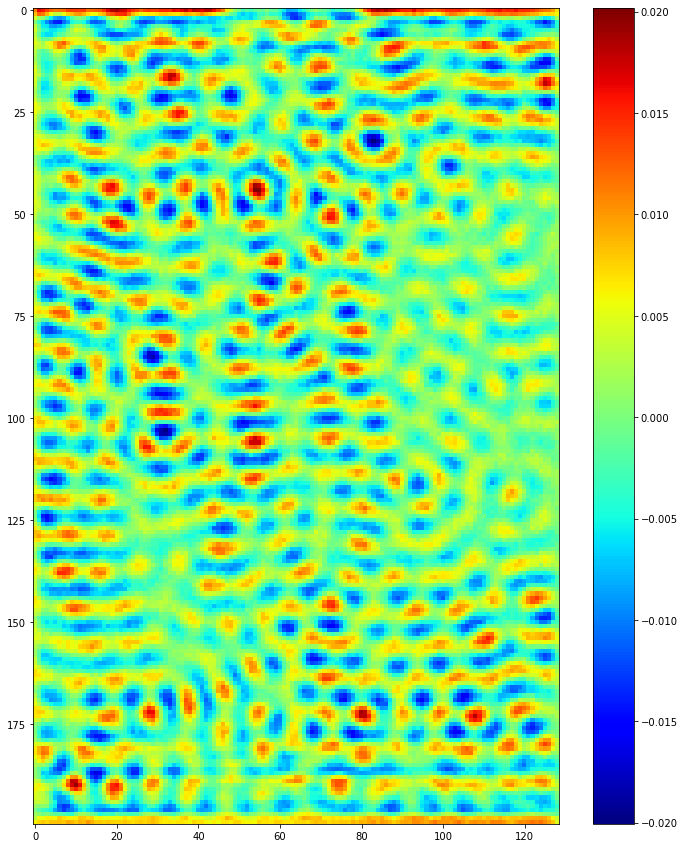

In [65]:
div = losses.get_div_field(pred[...,0],pred[...,1],dx,dy,1,2)
print(np.mean(div**2),losses.divergence(pred[...,0],pred[...,1],dx,dy,1,2))
plt.figure(figsize=(12,15))
plt.imshow(div[3,...],'jet')
plt.colorbar()
plt.show()

0.00855558


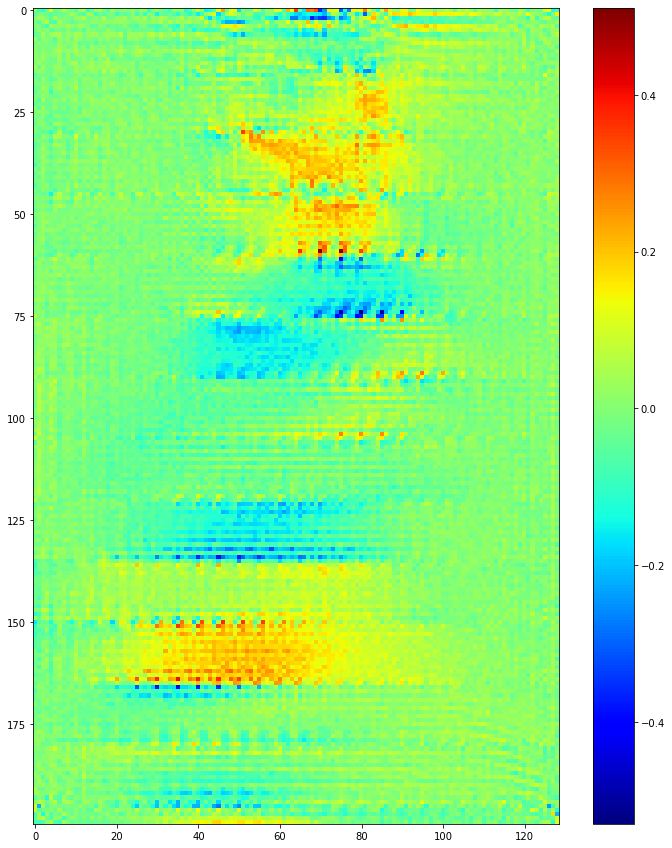

In [66]:
plt.figure(figsize=(12,15))
temp = pred
r = momentum_residue(2,
            ux=temp[...,0],
            uy=temp[...,1],
            p=temp[...,2],
            re=100,
            dt=dt,
            dx=dx,
            dy=dy,
            axis_idx=[0,1,2]
            )
print(np.mean(r**2))
plt.imshow(r[3,...],'jet')
plt.colorbar()
plt.show()